In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import datetime
figsize(12, 8)

Populating the interactive namespace from numpy and matplotlib


In [242]:
def massage_data(run):
    # Filter some nonsense values
    run.linuxtime = run.linuxtime.apply(datetime.datetime.fromtimestamp)
    run.rpm = run.rpm.apply(lambda x: x if x < 4000 and x > 1 else np.nan)
    run.ds_volt = run.ds_volt.apply(lambda x: x if x < 400 and x > 100 else np.nan)
    run.ds_cur_48v = run.ds_cur_48v.apply(lambda x: x if x > 0 else np.nan)
    
    # Fill forward
    run.fillna(method='pad', inplace=True)
    
    run.set_index(run.linuxtime, drop=True, inplace=True)
    del run["linuxtime"]
    del run["time"]
#     del run["soc"]
    for col in run:
        run[col].index = run.index

    return run

In [243]:
run9 = pd.read_csv("test_logs/2016-07-01_run9.csv")
run9 = massage_data(run9)

In [244]:
run10 = pd.read_csv("test_logs/2016-07-01_run10.csv")
run10 = massage_data(run10)

## Overview

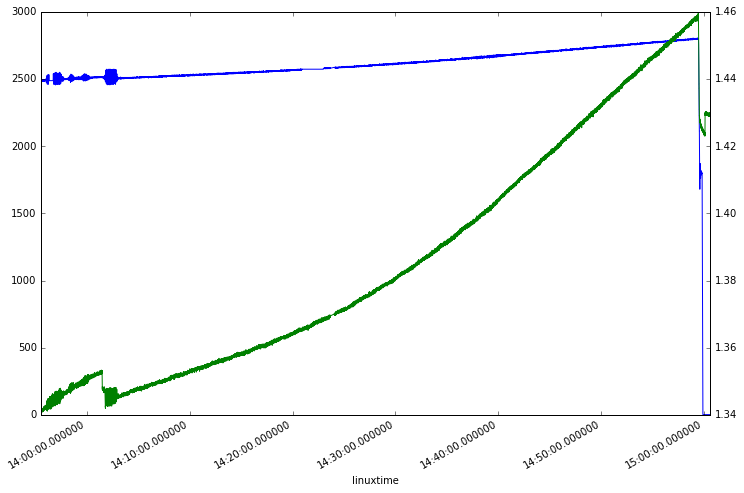

In [245]:
# Combine the two
run = run9.append(run10)
run.rpm.plot()
run.an_volt.plot(secondary_y=True)

## Fit analog input to DeepSea Values

In [219]:
def fit_and_plot(x, y):
    fit = np.polyfit(x, y, 1)
    plt.plot(x, y, '.')
    plt.plot(x, np.poly1d(fit)(x))
    return fit

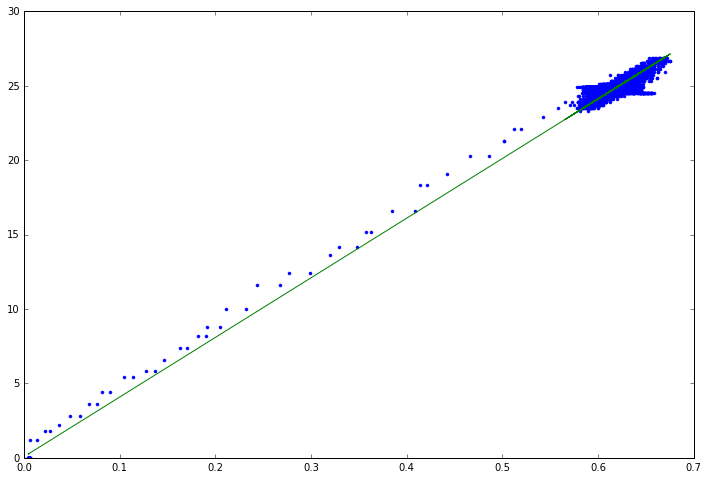

In [220]:
cur_fit = fit_and_plot(run.an_cur_300v, run.ds_cur_300v)

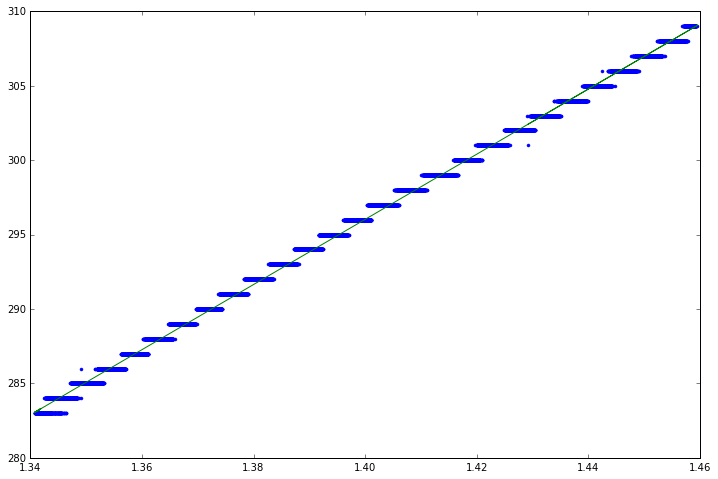

In [221]:
volt_fit = fit_and_plot(run.an_volt, run.ds_volt)

In [222]:
print("Analog current formula: %.4fx + %.4f"%(cur_fit[0], cur_fit[1]))
print("Analog voltage formula: %.4fx + %.4f"%(volt_fit[0], volt_fit[1]))

Analog current formula: 40.0683x + 0.0724
Analog voltage formula: 218.9745x + -10.5411


In [223]:
# Apply the scales
run.an_volt = run.an_volt * volt_fit[0] + volt_fit[1]
run.an_cur_300v = run.an_cur_300v * cur_fit[0] + cur_fit[1]

## Examine turnoff sequence

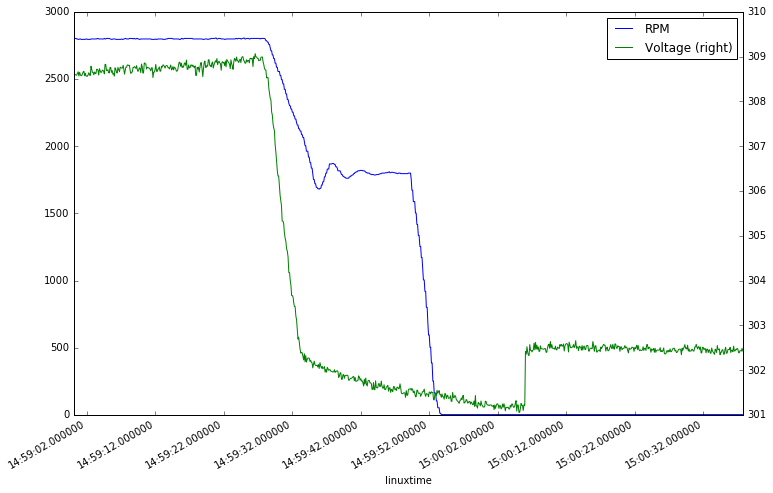

In [224]:
end = run["2016-07-01 14:59":"2016-07-01 15:00"]
end.rpm.plot(label="RPM", legend=True)
end.an_volt.plot(label="Voltage", legend=True, secondary_y=True)

## Examine resonance area

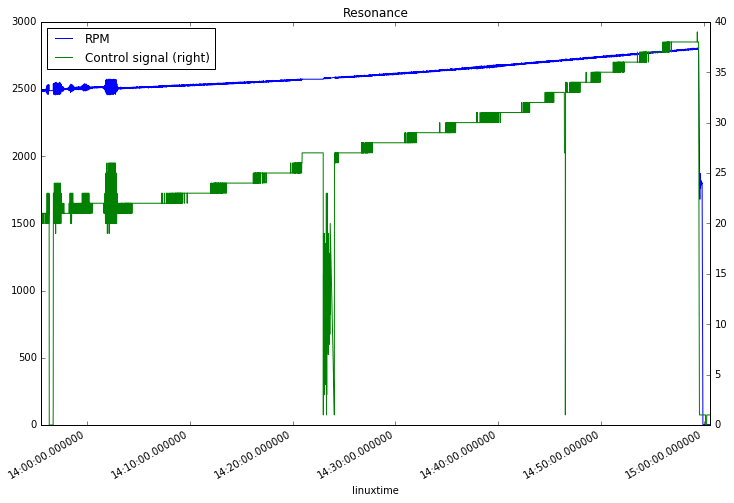

In [246]:
resonance = run#["2016-07-01 14:02:20":"2016-07-01 14:03:00"]
resonance.rpm.plot(title="Resonance", label="RPM", legend=True)
resonance.soc.plot(secondary_y=True, label="Control signal", legend=True)
figure()

In [247]:
run.head()

,rpm,ds_volt,ds_cur_300v,ds_cur_48v,soc,ds_bat_cur,an_cur_300v,an_volt
linuxtime,,,,,,,,
2016-07-01 13:55:31.340,2488.0,283.0,25.1,NaN,4.0,251.0,0.622000,1.341500
2016-07-01 13:55:31.450,2488.0,283.0,24.9,NaN,1.0,251.0,0.623938,1.341719
2016-07-01 13:55:31.560,2492.0,283.0,24.9,NaN,1.0,249.0,0.622563,1.341063
2016-07-01 13:55:31.680,2492.0,283.0,24.9,NaN,11.0,249.0,0.629219,1.341406
2016-07-01 13:55:31.780,2495.0,283.0,25.1,NaN,11.0,249.0,0.623625,1.341469
